In [59]:
import numpy as np
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

def create_genes(dimensions=2, space=10):
    """Creates a list with N random elements normally distributed

    Args:
        dimensions (int, optional): Number of genes. Defaults to 2.
        space (int, optional): Average of the random generated values. Defaults to 10.

    Returns:
        array: Array n*1 with the genes
    """

    genes = -space+2*space*np.random.rand(dimensions)
    return genes


def calc_fitness(genes, func=None):
    """Calculates the fitness of the genes

    Args:
        genes (array): Array with the genes
        func (int): Integer to look the function

    Raises:
        ValueError: If the fitness function is not found

    Returns:
        double: fitness value of the function
    """

    func_list =  ["sphere","rosenbrock", "rastring"]
    func = func_list[func]
    if func not in ["sphere", "rosenbrock", "rastring"]:
        raise ValueError("Fitness function not recognized")
    # Fitnessfunktion ist die Multiplikation aller N Elemente
    if func == "sphere":
        fitness = np.dot(genes, genes)
        return fitness

    if func == "rosenbrock":
        fitness = 0
        for i in range(len(genes) - 1):
            x = genes[i]
            y = genes[i + 1]
            fitness += 100 * (x * x - y) ** 2 + (x - 1) ** 2
        return fitness

    if func == "rastring":
        a = 10
        n = len(genes)
        fitness = a * n
        for i in range(n):
            x = genes[i]
            fitness += x * x - a * np.cos(2 * np.pi * x) # wikipedia says minus!!
        return fitness

class Organism(object):
    """General data class to store information
    """

    def __init__(self, genes=None, sigma=None,func=None, generation = None) -> None:
        self.genes = genes
        self.sigma = sigma
        self.func = func
        self.fitness = None
        self.generation = generation
        if genes is not None:
            
            self.calc_fitness()

    
    def calc_fitness(self):
        """Calculates the fitness of the genes
        """
        self.fitness=calc_fitness(genes=self.genes, func = self.func)

In [60]:
ITERATIONS = 2000 #100, 1000
GENOMES = 2  # N
N = GENOMES
METHOD = 0  # ["sphere","rosenbrock", "rastring"]
SIGMA_START = 1
ALPHA = 10
d = np.sqrt(N+1)
kappa = 20

covar = np.identity(N)

# 1 Parent
parent_genes = create_genes(dimensions=GENOMES,space=10)
parent = Organism(genes = parent_genes, sigma =SIGMA_START, func = METHOD)
parent.calc_fitness()

#Data saving
parent_list = [parent.genes]
fitness_list = [parent.fitness]
sigma_list = [parent.sigma]
covar_max_list = [covar]
sigma_vector_list=[]
iter = 0
A = []
sigma = SIGMA_START
while iter <= ITERATIONS: 
    iter +=1
    if iter%kappa == 0 and len(A)>1:
        covar = np.cov(np.transpose(A))
    sigma_vector = sigma* np.random.multivariate_normal(mean=[0 for _ in range(N)], cov = covar)
    child_genes = parent.genes + sigma_vector
    
    # New child
    child = Organism(genes = child_genes, func=METHOD)
    child.calc_fitness()

    # Rechenberg selector
    if child.fitness<=parent.fitness:
        rech= 4/5
    else:
        rech = -1/5
    sigma = sigma*np.exp(1/d*rech)

    if child.fitness<parent.fitness:
        parent = child
        if len(A)>=ALPHA:
            A = A[1:ALPHA]
            A.append(parent.genes)
        else:
            A.append(parent.genes)

            
    parent_list.append(parent.genes)
    fitness_list.append(parent.fitness)
    sigma_list.append(sigma)
    covar_max_list.append(covar)
    sigma_vector_list.append(sigma_vector)
#print(sigma_list)
sigma_vector_list.append(sigma_vector_list[-1])
if METHOD == 2:
    fitness_list = [abs(f-1) for f in fitness_list]


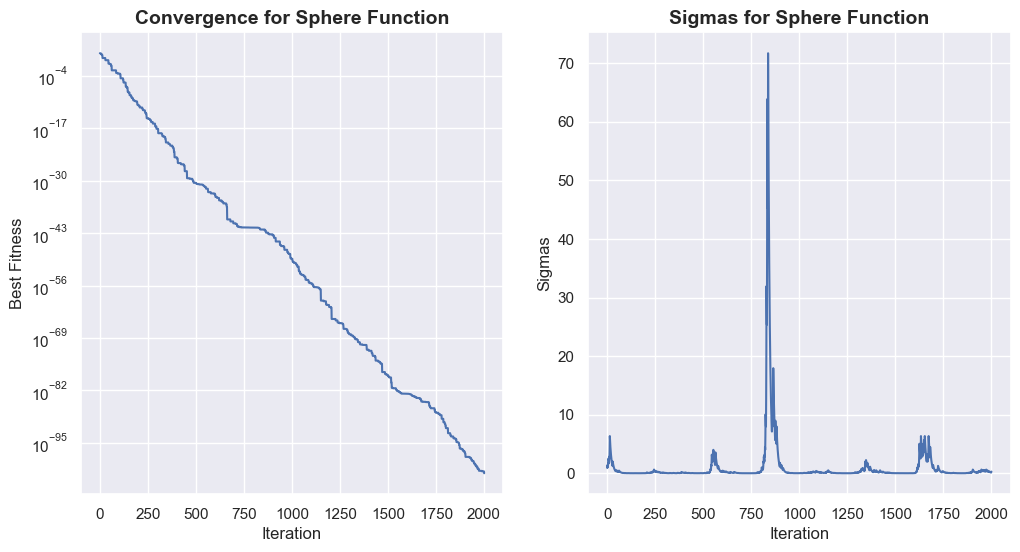

In [61]:

import seaborn as sns
sns.set_style("darkgrid")
sns.set(font = "arial")
names = ["Sphere", "Rosenbrock", "Rastrigin"]
fig,axs= plt.subplots(1,2,figsize = (12,6))
ax= axs[0]
ax.plot(fitness_list)
#df_sigmas["sigmas"].plot(ax=ax)
ax.set_xlabel("Iteration")
ax.set_ylabel("Best Fitness")
ax.set_yscale("log")
#ax.set_ylim(bottom = min(res["rosenbrock"]))
ax.set_title(f"Convergence for {names[METHOD]} Function", fontsize= 14, fontweight = "bold")

ax= axs[1]
ax.plot(sigma_list)
#df_sigmas["sigmas"].plot(ax=ax)
ax.set_xlabel("Iteration")
ax.set_ylabel("Sigmas")
#ax.set_yscale("log")
#ax.set_ylim(bottom = min(res["rosenbrock"]))
ax.set_title(f"Sigmas for {names[METHOD]} Function", fontsize= 14, fontweight = "bold")
fig.savefig(f"results/cov_mx_convg_f_{METHOD}.png", dpi=600)


In [62]:
results = {"parent":   parent_list,
    "fitness":fitness_list,
    "sigma": sigma_list,
    "sigma_v": sigma_vector_list,
    "covar": covar_max_list}

df = pd.DataFrame.from_dict(results)
import seaborn as sns
sns.set_style("darkgrid")
sns.set(font = "arial")
df.to_csv("results/covar.csv")

In [63]:
# Plot of the path of the results
ran = 10
x = np.linspace(-ran,ran,num=201)
y = np.linspace(-ran,ran,num=201)

X, Y = np.meshgrid(x,y)
Z = np.zeros((201,201))

for i in range(201):
   for j in range(201):
       Z[i,j] = calc_fitness((X[i,j],Y[i,j]), METHOD)


C:\Users\ferna\AppData\Local\Temp\ipykernel_20912\3248948760.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


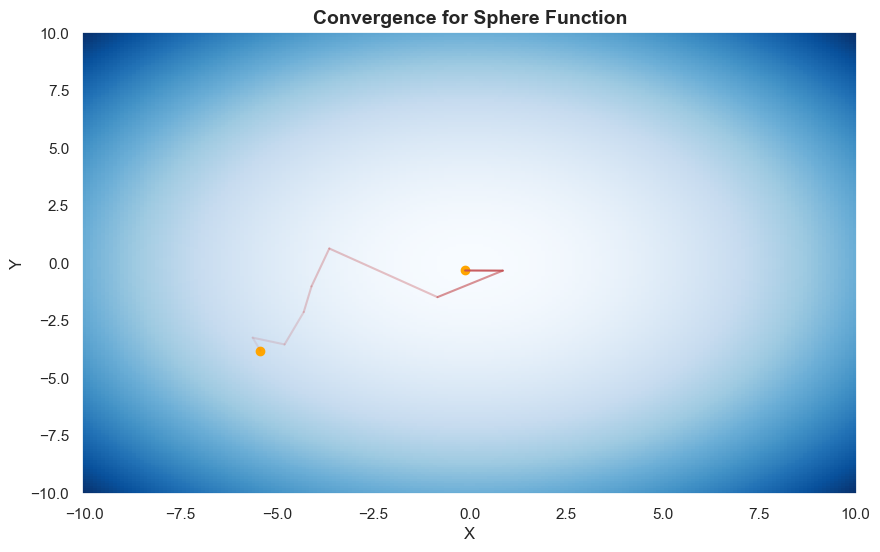

In [64]:
fig,ax= plt.subplots(figsize = (10,6))
#df_sigmas["sigmas"].plot(ax=ax)
ax.set_xlabel("X")
ax.set_ylabel("Y")
#ax.set_ylim(bottom = min(res["rosenbrock"]))
ax.set_title(f"Convergence for {names[METHOD]} Function", fontsize= 14, fontweight = "bold")
ax.pcolor(X, Y, Z,cmap="Blues")

ax.scatter([parent_list[0][0],parent_list[51][0]],[parent_list[0][1],parent_list[51][1]],color = "orange")
alphas = np.linspace(0.1,1,num=50)
for i in range(50):
    ax.plot([parent_list[i][0],parent_list[i+1][0]],[parent_list[i][1],parent_list[i+1][1]], 'r', alpha=alphas[i])

fig.show()

fig.savefig(f"results/cov_mx_path_f_{METHOD}.png", dpi=600)


C:\Users\ferna\AppData\Local\Temp\ipykernel_20912\3457147242.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


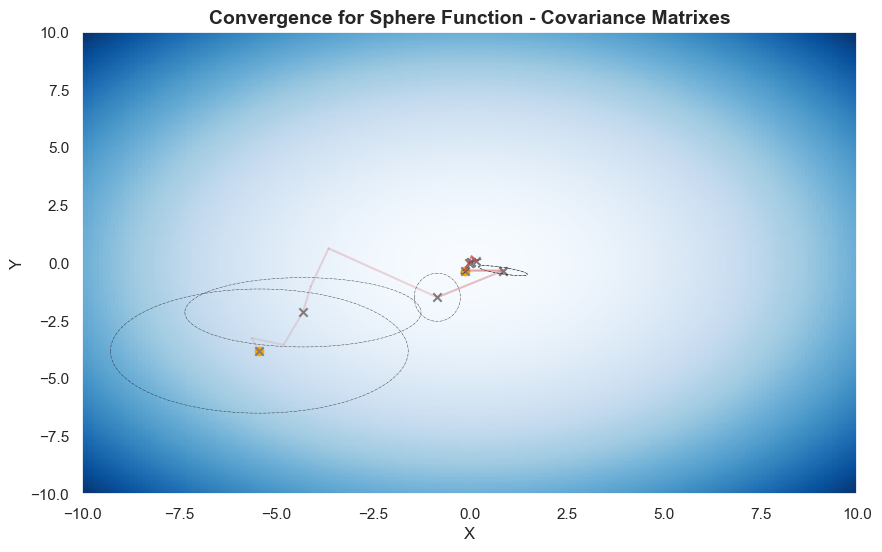

In [65]:
#plot a rotated ellipse
def get_ellipse(covar_matrix, center,sigma):
    thetas = np.linspace(0,2*np.pi,201)
    x=[]
    y=[]
    norr = np.linalg.norm(covar_matrix)
    for t in thetas:
        v =np.dot(covar_matrix,np.array([np.cos(t),np.sin(t)]))
        x.append(sigma/norr*v[0]*center[0]+center[0])
        y.append(sigma/norr*v[1]*center[1]+center[1])
    return x,y

fig,ax= plt.subplots(figsize = (10,6))
#df_sigmas["sigmas"].plot(ax=ax)
ax.set_xlim(left= -10, right = 10)
ax.set_ylim(top= 10, bottom = -10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title(f"Convergence for {names[METHOD]} Function - Covariance Matrixes", fontsize= 14, fontweight = "bold")

ax.pcolor(X, Y, Z,cmap="Blues")

ax.scatter([parent_list[0][0],parent_list[51][0]],[parent_list[0][1],parent_list[51][1]],color = "orange")
MAX_P = 100
alphas = np.linspace(0.1,1,num=MAX_P)
for i in range(MAX_P):
    ax.plot([parent_list[i][0],parent_list[i+1][0]],[parent_list[i][1],parent_list[i+1][1]], 'r', alpha=alphas[i])
    if (i+1)%10 ==0 or i ==MAX_P or i == 0:
        x,y = get_ellipse(covar_max_list[i], center = parent_list[i], sigma =1)# sigma_list[i] )#sigma_list[i])
        ax.plot(x,y, linestyle = "-.", color = "k", linewidth = 0.3)
        ax.scatter(parent_list[i][0],parent_list[i][1],marker="x", color = "gray")
fig.show()
fig.savefig(f"results/cov_mx_elipses_f_{METHOD}.png", dpi=600)



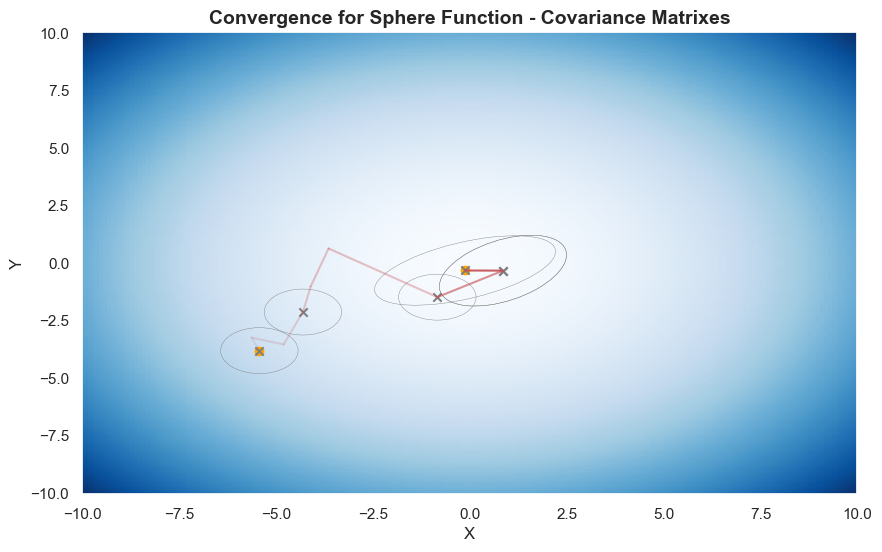

In [66]:
#plot a rotated ellipse
from matplotlib.patches import Ellipse
from matplotlib import transforms
def get_ellipse(covar_matrix, center,sigma, ax, n_std = 1, facecolor = "none", edgecolor = "red", **kwargs):
    cov = covar_matrix
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, edgecolor = edgecolor, **kwargs)
    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = center[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = center[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)

    return ax.add_patch(ellipse)

fig,ax= plt.subplots(figsize = (10,6))
#df_sigmas["sigmas"].plot(ax=ax)
ax.set_xlim(left= -10, right = 10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Convergence for Sphere Function - Covariance Matrixes", fontsize= 14, fontweight = "bold")

ax.pcolor(X, Y, Z,cmap="Blues")

ax.scatter([parent_list[0][0],parent_list[51][0]],[parent_list[0][1],parent_list[51][1]],color = "orange")
alphas = np.linspace(0.1,1,num=50)
MAX_P = 100 #iterations to plot, cannot plot all or you get stuck
for i in range(50):
    ax.plot([parent_list[i][0],parent_list[i+1][0]],[parent_list[i][1],parent_list[i+1][1]], 'r', alpha=alphas[i])
    if (i+1)%10 ==0 or i ==MAX_P-1 or i == 0:
        get_ellipse(covar_matrix=covar_max_list[i], center=parent_list[i],sigma=1, ax=ax, n_std = 1,linewidth = 0.3,
                    edgecolor = "grey")
        #ax.plot(x,y, linestyle = "-.", color = "k", linewidth = 0.3)
        ax.scatter(parent_list[i][0],parent_list[i][1],marker="x", color = "gray")
#fig.show()
#fig.savefig(f"convergence_path_elipses_f_{METHOD}_v2.png", dpi=600)
